In [ ]:
# pip install tensorflow==2.17.0

In [32]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,accuracy_score

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
print(tf.__version__)

2.17.1


In [4]:
# import os
# import shutil
# import random
# # Fungsi untuk membuat struktur folder dan membagi data
# def split_data(source_dir, base_dir, train_size=0.8, val_size=0.1, test_size=0.1):
#     # Membuat folder utama untuk train, val, dan test
#     os.makedirs(base_dir, exist_ok=True)
#     train_dir = os.path.join(base_dir, 'train')
#     val_dir = os.path.join(base_dir, 'val')
#     test_dir = os.path.join(base_dir, 'test')

#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(val_dir, exist_ok=True)
#     os.makedirs(test_dir, exist_ok=True)

#     categories = os.listdir(source_dir)

#     # Untuk setiap kategori, buat folder di train, val, test dan pindahkan gambar
#     for category in categories:
#         category_dir = os.path.join(source_dir, category)
#         files = os.listdir(category_dir)
#         random.shuffle(files)

#         # Menghitung jumlah data untuk training, validation, dan testing
#         total_files = len(files)
#         train_count = int(train_size * total_files)
#         val_count = int(val_size * total_files)
#         test_count = total_files - train_count - val_count  # Sisanya untuk test

#         # Buat folder untuk kategori di setiap subset
#         os.makedirs(os.path.join(train_dir, category), exist_ok=True)
#         os.makedirs(os.path.join(val_dir, category), exist_ok=True)
#         os.makedirs(os.path.join(test_dir, category), exist_ok=True)

#         # Pindahkan file ke folder masing-masing
#         for i, file in enumerate(files):
#             source_file = os.path.join(category_dir, file)

#             if i < train_count:
#                 target_dir = os.path.join(train_dir, category)
#             elif i < train_count + val_count:
#                 target_dir = os.path.join(val_dir, category)
#             else:
#                 target_dir = os.path.join(test_dir, category)

#             shutil.copy(source_file, target_dir)

# # Tentukan direktori sumber dan tujuan
# source_dir = '/content/drive/MyDrive/BEAUSKIN ML/SKIN_TYPES_DATASET'
# base_dir = '/content/drive/MyDrive/BEAUSKIN ML/SKINTYPES_DETECTION'

# # Panggil fungsi untuk membagi dataset
# split_data(source_dir, base_dir)


In [34]:
# Data generator untuk training
datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   validation_split=0.2)

In [35]:
train_dir = '/content/drive/MyDrive/BEAUSKIN ML/SKINTYPES_DETECTION/train'
val_dir = '/content/drive/MyDrive/BEAUSKIN ML/SKINTYPES_DETECTION/val'
test_dir = '/content/drive/MyDrive/BEAUSKIN ML/SKINTYPES_DETECTION/test'

In [36]:
train_generator = datagen.flow_from_directory(train_dir,
                                                  target_size=(128,128),
                                                  color_mode="rgb",
                                                  class_mode="categorical")

valid_generator = datagen.flow_from_directory(val_dir,
                                                    target_size=(128,128),
                                                    color_mode="rgb",
                                                    class_mode="categorical")

test_datagen = ImageDataGenerator(rescale =1./255)
test_generator = datagen.flow_from_directory(test_dir,
                                                   target_size=(128,128),
                                                   color_mode="rgb",
                                                   class_mode="categorical")

Found 1649 images belonging to 3 classes.
Found 205 images belonging to 3 classes.
Found 207 images belonging to 3 classes.


In [37]:
# Mendapatkan label dari train_generator
class_labels = train_generator.class_indices
print("Class Labels:", class_labels)

Class Labels: {'dry': 0, 'normal': 1, 'oily': 2}


In [38]:
# Load MobileNetV2 dengan pretrained weights dari ImageNet, tanpa lapisan top
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [39]:
base_model.trainable = False

In [40]:
# Memulai dengan input base model
x = base_model.output

# Tambahkan lapisan pooling global
x = GlobalAveragePooling2D()(x)

# Tambahkan lapisan Dense untuk klasifikasi
x = Dense(128, activation='relu')(x)
x = Dense(3, activation='softmax')(x)  # 3 output neurons untuk 3 kelas kulit

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
# model.compile(optimizer=Adam(),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [42]:
# Definisikan optimizer dengan NAG
optimizer = SGD( momentum=0.9, nesterov=True)

# Kompilasi model dengan optimizer NAG
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
# Training model
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=20,
                    verbose = 1,
                    )

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 51s 874ms/step - accuracy: 0.9536 - loss: 0.1153 - val_accuracy: 0.9512 - val_loss: 0.1420
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 44s 773ms/step - accuracy: 0.9470 - loss: 0.1158 - val_accuracy: 0.9512 - val_loss: 0.1411
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 778ms/step - accuracy: 0.9603 - loss: 0.0992 - val_accuracy: 0.9268 - val_loss: 0.2217
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 773ms/step - accuracy: 0.9510 - loss: 0.1291 - val_accuracy: 0.9122 - val_loss: 0.2504
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 82s 775ms/step - accuracy: 0.9652 - loss: 0.0977 - val_accuracy: 0.9366 - val_loss: 0.1824
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 86s 859ms/step - accuracy: 0.9656 - loss: 0.0909 - val_accuracy: 0.9463 - val_loss: 0.1863
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 46s 825ms/step - accuracy: 0.9668 - loss: 0.0803 - val_accuracy: 0.9610 - val_loss: 0.1392
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 776ms/step - accuracy: 0.9661 - loss: 0.0815 - val_accu

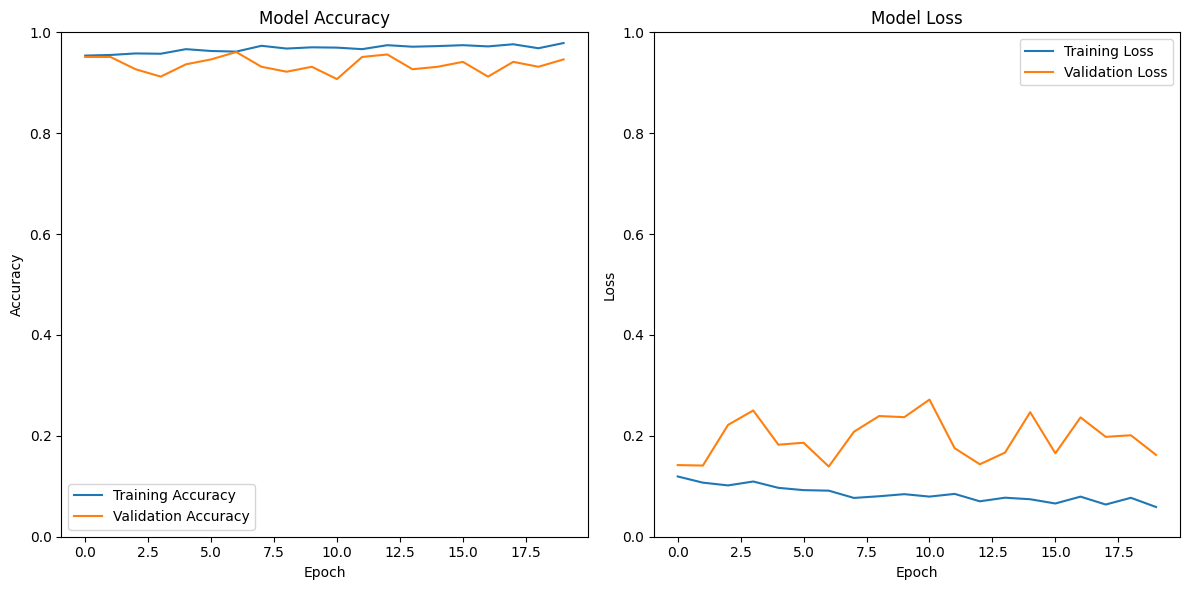

In [46]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))  # Increase figure size for better clarity

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0, 1])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()


In [48]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 595ms/step - accuracy: 0.9911 - loss: 0.0526
Test Loss: 0.07421942800283432
Test Accuracy: 0.9791666865348816


In [49]:
model.save('/content/drive/MyDrive/model fix/skintypes_detection_model.h5')

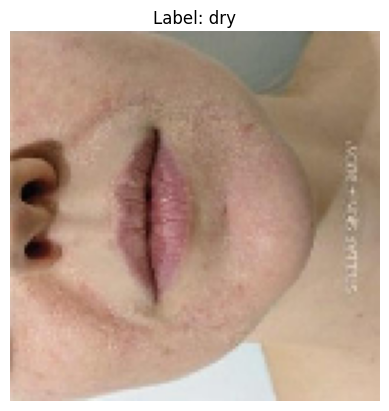

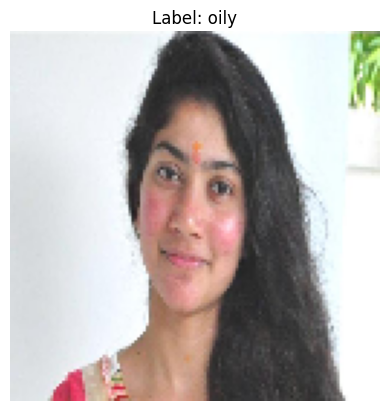

In [126]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


# Get the list of categories (subfolders)
categories = os.listdir(test_dir)

# Function to load and display a random image with its label
def load_and_display_random_image_with_label():
    # Randomly select a category (label)
    category = random.choice(categories)

    # Get the list of image files in the selected category
    category_path = os.path.join(test_dir, category)
    files = os.listdir(category_path)

    # Randomly select a file
    selected_file = random.choice(files)
    selected_image_path = os.path.join(category_path, selected_file)

    # Load and preprocess the image
    img = image.load_img(selected_image_path, target_size=(128, 128))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"Label: {category}")  # Display the label as title
    plt.show()

# Display two random images with their labels
for _ in range(2):
    load_and_display_random_image_with_label()
